In [ ]:
This code follows the tutorial at: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [1]:
import nltk; nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [Errno 8] nodename
[nltk_data]     nor servname provided, or not known>


False

In [2]:
!python -m spacy download en


    Linking successful
    /Users/sierrawulfson/opt/anaconda3/envs/cs6220/lib/python3.7/site-packages/en_core_web_sm
    -->
    /Users/sierrawulfson/opt/anaconda3/envs/cs6220/lib/python3.7/site-packages/spacy/data/en

    You can now load the model via spacy.load('en')



In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import preprocessor as p

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
# NLTK Stop words
#from nltk.corpus import stopwords
#stop_words = stopwords.words('english')
#stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [3]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'use', 'ourselves', 'hers', 'between', 'yourself', 'but', 'again', 'there',
                   'about', 'once', 'during', 'out', 'very', 'having', 'with', 'they', 'own', 'an', 
                   'be', 'some', 'for', 'do', 'its', 'yours', 'such', 'into', 'of', 'most', 'itself',
                   'other', 'off', 'is', 's', 'am', 'or', 'who', 'as', 'from', 'him', 'each', 'the', 
                   'themselves', 'until', 'below', 'are', 'we', 'these', 'your', 'his', 'through', 'don', 
                   'nor', 'me', 'were', 'her', 'more', 'himself', 'this', 'down', 'should', 'our', 'their',
                   'while', 'above', 'both', 'up', 'to', 'ours', 'had', 'she', 'all', 'no', 'when', 'at', 
                   'any', 'before', 'them', 'same', 'and', 'been', 'have', 'in', 'will', 'on', 'does', 
                   'yourselves', 'then', 'that', 'because', 'what', 'over', 'why', 'so', 'can', 'did', 
                   'not', 'now', 'under', 'he', 'you', 'herself', 'has', 'just', 'where', 'too', 'only',
                   'myself', 'which', 'those', 'i', 'after', 'few', 'whom', 't', 'being', 'if', 'theirs', 
                   'my', 'against', 'a', 'by', 'doing', 'it', 'how', 'further', 'was', 'here', 'than', 'th',
                   'go', 'whos', 'ive', 'etc','http', 'https' ,'amp''my', 'against', 'a', 'by', 'doing', 'it',
                   'how', 'further', 'was', 'here', 'than', 'th',
                  'go', 'whos', 'ive', 'etc', 'fake', 'fake_new', 'fake_news', 'melania', 'hillary', 'crooked', 
                   'james_comey', 'puerto_rico', 'hurricane', 'vote', 'crooked' ,'hillary_clinton' ,
                    'rally', 'florida', 'nyc', 'alabama', 'ohio', 'kentucky', 'thankyoutoour', 'trump', 
                    'fakenew', 'electoral_college','north_carolina'])

df = pd.read_csv("../tweets_sentiments4dla.csv", index_col=0)

# Convert to list
data = df.text.values.tolist()

## cleaning
p.set_options(p.OPT.EMOJI, p.OPT.SMILEY)
data = [p.clean(sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]
# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])


['A great try by . We are all proud of you!']


In [4]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['great', 'try', 'by', 'we', 'are', 'all', 'proud', 'of', 'you']]


In [5]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['great', 'try', 'by', 'we', 'are', 'all', 'proud', 'of', 'you']


In [6]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [7]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['great', 'try', 'proud']]


In [8]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1)]]


In [12]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
#ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [11]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(9,
  [('people', 0.04693548387096774),
   ('work', 0.036774193548387096),
   ('speak', 0.029838709677419355),
   ('leave', 0.02661290322580645),
   ('florida', 0.025161290322580646),
   ('close', 0.02129032258064516),
   ('safe', 0.020161290322580645),
   ('prime_minister', 0.01935483870967742),
   ('state', 0.01467741935483871),
   ('hurricane', 0.012741935483870967)]),
 (15,
  [('people', 0.09018247624792641),
   ('democrat', 0.0830945558739255),
   ('country', 0.07811793093047806),
   ('wall', 0.05217915849796411),
   ('security', 0.0414718745287287),
   ('stop', 0.035892022319408835),
   ('build', 0.030312170110088976),
   ('include', 0.025787965616045846),
   ('southern_border', 0.0208113406725984),
   ('party', 0.020208113406725983)]),
 (11,
  [('news', 0.12718460860625644),
   ('medium', 0.06535467763254516),
   ('story', 0.042590688794242916),
   ('bad', 0.03862534880305478),
   ('report', 0.025113819944191512),
   ('watch', 0.023204582170656483),
   ('corrupt', 0.02041415773

In [13]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        model_topics = model.show_topics(formatted=False)
        pprint(model.print_topics(num_topics=num_topics, num_words=50))
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [14]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=5, limit=10, step=1)

[(0,
  '0.040*"democrat" + 0.028*"american" + 0.027*"work" + 0.019*"republican" + '
  '0.016*"border" + 0.016*"deal" + 0.015*"give" + 0.014*"wall" + '
  '0.012*"security" + 0.012*"hard" + 0.011*"dem" + 0.010*"end" + '
  '0.009*"support" + 0.009*"family" + 0.009*"include" + 0.009*"senate" + '
  '0.008*"house" + 0.008*"build" + 0.008*"national" + 0.008*"bill" + '
  '0.008*"put" + 0.007*"continue" + 0.007*"dollar" + 0.007*"tax_cut" + '
  '0.007*"law" + 0.007*"vote" + 0.006*"act" + 0.006*"order" + 0.006*"live" + '
  '0.005*"pass" + 0.005*"announce" + 0.005*"agree" + 0.005*"remember" + '
  '0.005*"drug" + 0.005*"spend" + 0.005*"iran" + 0.005*"begin" + 0.004*"part" '
  '+ 0.004*"home" + 0.004*"month" + 0.004*"major" + 0.004*"fast" + '
  '0.004*"healthcare" + 0.004*"fix" + 0.004*"office" + 0.004*"care" + '
  '0.004*"kill" + 0.004*"plan" + 0.004*"hold" + 0.004*"court"'),
 (1,
  '0.054*"president" + 0.049*"people" + 0.022*"state" + 0.016*"crime" + '
  '0.016*"strong" + 0.015*"military" + 0.013*

[(0,
  '0.037*"democrat" + 0.032*"border" + 0.026*"people" + 0.026*"republican" + '
  '0.020*"crime" + 0.020*"military" + 0.019*"country" + 0.018*"wall" + '
  '0.017*"security" + 0.015*"congress" + 0.014*"work" + 0.013*"fight" + '
  '0.013*"mexico" + 0.013*"end" + 0.013*"support" + 0.013*"stop" + '
  '0.012*"include" + 0.012*"senate" + 0.012*"house" + 0.011*"build" + '
  '0.010*"bill" + 0.009*"protect" + 0.009*"law" + 0.009*"act" + 0.009*"vote" + '
  '0.008*"sign" + 0.007*"pass" + 0.007*"southern_border" + 0.007*"tough" + '
  '0.007*"party" + 0.007*"drug" + 0.006*"reason" + 0.006*"close" + 0.006*"dem" '
  '+ 0.006*"major" + 0.006*"law_enforcement" + 0.006*"member" + 0.006*"fix" + '
  '0.006*"care" + 0.005*"kill" + 0.005*"change" + 0.005*"safety" + '
  '0.005*"attack" + 0.005*"finally" + 0.005*"send" + 0.005*"immigration" + '
  '0.005*"system" + 0.005*"policy" + 0.005*"syria" + 0.004*"dangerous"'),
 (1,
  '0.074*"president" + 0.038*"american" + 0.037*"today" + 0.025*"day" + '
  '0.018*"

[(0,
  '0.089*"people" + 0.049*"work" + 0.029*"give" + 0.022*"bad" + 0.022*"hard" + '
  '0.018*"show" + 0.013*"wonderful" + 0.012*"important" + 0.012*"true" + '
  '0.011*"friend" + 0.011*"false" + 0.011*"order" + 0.010*"include" + '
  '0.010*"man" + 0.010*"justice" + 0.010*"family" + 0.009*"terrible" + '
  '0.008*"week" + 0.007*"force" + 0.007*"kill" + 0.007*"lawyer" + '
  '0.006*"judge" + 0.006*"attack" + 0.006*"destroy" + 0.006*"smart" + '
  '0.006*"person" + 0.006*"million" + 0.006*"power" + 0.006*"sad" + '
  '0.006*"prayer" + 0.006*"thing" + 0.005*"special" + 0.005*"stay" + '
  '0.005*"agenda" + 0.005*"child" + 0.005*"federal" + 0.005*"horrible" + '
  '0.005*"chance" + 0.005*"term" + 0.004*"biden" + 0.004*"matter" + '
  '0.004*"thought" + 0.004*"fine" + 0.004*"hate" + 0.004*"hour" + '
  '0.004*"voter" + 0.004*"effort" + 0.004*"choice" + 0.004*"department" + '
  '0.004*"anti"'),
 (1,
  '0.055*"news" + 0.028*"medium" + 0.021*"russia" + 0.020*"collusion" + '
  '0.018*"fbi" + 0.018*"st

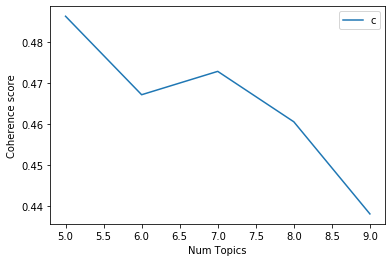

In [15]:
# Show graph
limit=10; start=5; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [16]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 5  has Coherence Value of 0.4863
Num Topics = 6  has Coherence Value of 0.4671
Num Topics = 7  has Coherence Value of 0.4728
Num Topics = 8  has Coherence Value of 0.4605
Num Topics = 9  has Coherence Value of 0.438


In [17]:
# Select the model and print the topics
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=50))

[(0,
  '0.037*"democrat" + 0.032*"border" + 0.026*"people" + 0.026*"republican" + '
  '0.020*"crime" + 0.020*"military" + 0.019*"country" + 0.018*"wall" + '
  '0.017*"security" + 0.015*"congress" + 0.014*"work" + 0.013*"fight" + '
  '0.013*"mexico" + 0.013*"end" + 0.013*"support" + 0.013*"stop" + '
  '0.012*"include" + 0.012*"senate" + 0.012*"house" + 0.011*"build" + '
  '0.010*"bill" + 0.009*"protect" + 0.009*"law" + 0.009*"act" + 0.009*"vote" + '
  '0.008*"sign" + 0.007*"pass" + 0.007*"southern_border" + 0.007*"tough" + '
  '0.007*"party" + 0.007*"drug" + 0.006*"reason" + 0.006*"close" + 0.006*"dem" '
  '+ 0.006*"major" + 0.006*"law_enforcement" + 0.006*"member" + 0.006*"fix" + '
  '0.006*"care" + 0.005*"kill" + 0.005*"change" + 0.005*"safety" + '
  '0.005*"attack" + 0.005*"finally" + 0.005*"send" + 0.005*"immigration" + '
  '0.005*"system" + 0.005*"policy" + 0.005*"syria" + 0.004*"dangerous"'),
 (1,
  '0.074*"president" + 0.038*"american" + 0.037*"today" + 0.025*"day" + '
  '0.018*"

In [18]:
#find dominant topic in each sentence
def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(20)




,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,5.0,0.1758,"great, big, state, win, america, love, congrat...",A great try by . We are all proud of you!
1,1,5.0,0.1927,"great, big, state, win, america, love, congrat...",Vote for Sean Spicer on Dancing with the Stars...
2,2,4.0,0.2048,"news, people, bad, medium, call, thing, story,...",“This isn’t about Ukraine. This isn’t about Im...
3,3,6.0,0.1725,"democrat, give, russia, collusion, dem, fbi, w...",want that to be an impeachable offense? Good l...
4,4,2.0,0.1812,"good, year, job, time, election, strong, high,...",“The President has until September 30th to giv...
5,5,6.0,0.1820,"democrat, give, russia, collusion, dem, fbi, w...",Schiff and the Dems have created this whole th...
6,6,1.0,0.1585,"president, american, today, day, world, honor,...",In order to continue being the most Transparen...
7,7,4.0,0.1990,"news, people, bad, medium, call, thing, story,...",Just like Schiff fabricated my phone call he w...
8,8,6.0,0.1869,"democrat, give, russia, collusion, dem, fbi, w...",Schiff is giving Republicans NO WITNESSES NO L...
9,9,4.0,0.1914,"news, people, bad, medium, call, thing, story,...",Read the Transcript. It is PERFECT!


In [26]:
data = pd.read_csv("../tweets_sentiments2.csv")
data[['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']]=\
    df_dominant_topic[['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']]
print(data.columns)
data = data[['id_str', 'text', 'created_at', 'retweet_count', 'favorite_count',
       'is_retweet', 'neg', 'neu', 'pos', 'cmpd', 'date', 'time',
       'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords']]
data.to_csv('tweets_sents_lda.csv')


Index(['id_str', 'text', 'created_at', 'retweet_count', 'favorite_count',
       'is_retweet', 'neg', 'neu', 'pos', 'cmpd', 'date', 'time',
       'Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords',
       'Text'],
      dtype='object')


In [26]:
#find representative topics
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.3386,"great, america, republican, win, state, make, ...",Congratulations to Bryan Steil on a wonderful ...
1,1.0,0.3754,"country, make, china, deal, united_state, pay,...",China is subsidizing its product in order that...
2,2.0,0.3417,"news, bad, people, medium, time, call, story, ...",Another false story this time in the Failing t...
3,3.0,0.3353,"people, border, country, crime, strong, milita...",If we don’t have a wall system we’re not going...
4,4.0,0.3698,"democrat, election, give, russia, collusion, d...",“Conflict between Glen Simpson’s testimony to ...
5,5.0,0.3576,"president, american, today, day, world, honor,...",The citizens of Venezuela have suffered for to...
6,6.0,0.3663,"big, good, job, work, year, president, back, t...",On Taxes: “This is the biggest corporate rate ...


In [28]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0.0,"great, america, republican, win, state, make, ...",2063.0,0.1756
1.0,0.0,"great, america, republican, win, state, make, ...",1502.0,0.1279
2.0,2.0,"news, bad, people, medium, time, call, story, ...",1799.0,0.1532
3.0,2.0,"news, bad, people, medium, time, call, story, ...",1567.0,0.1334
4.0,1.0,"country, make, china, deal, united_state, pay,...",1697.0,0.1445
...,...,...,...,...
11740.0,0.0,"great, america, republican, win, state, make, ...",NaN,NaN
11741.0,5.0,"president, american, today, day, world, honor,...",NaN,NaN
11742.0,5.0,"president, american, today, day, world, honor,...",NaN,NaN
11743.0,5.0,"president, american, today, day, world, honor,...",NaN,NaN


In [9]:
def compute_coherence_valueslda(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in [7,13,16,29,30]: #range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [10]:
# Can take a long time to run.
model_list2, coherence_values2 = compute_coherence_valueslda(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=6, limit=31, step=1)

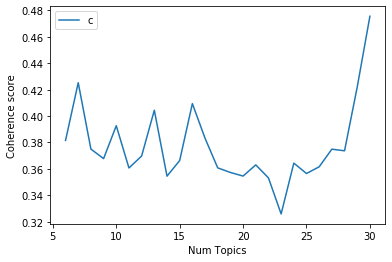

In [25]:
# Show graph
limit=31; start=6; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values2)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [13]:
# Print the coherence scores
x = [7,13,16,29,30]
for m, cv in zip(x, coherence_values2):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 7  has Coherence Value of 0.4253
Num Topics = 13  has Coherence Value of 0.4044
Num Topics = 16  has Coherence Value of 0.4095
Num Topics = 29  has Coherence Value of 0.422
Num Topics = 30  has Coherence Value of 0.4756


In [14]:
# Select the model and print the topics
optimal_model1 = model_list2[0]
model_topics1 = optimal_model1.show_topics(formatted=False)
pprint(optimal_model1.print_topics(num_words=50))

[(0,
  '0.034*"make" + 0.028*"president" + 0.027*"news" + 0.025*"not" + '
  '0.022*"many" + 0.022*"american" + 0.021*"say" + 0.020*"good" + 0.019*"year" '
  '+ 0.019*"medium" + 0.018*"go" + 0.017*"new" + 0.016*"call" + 0.013*"want" + '
  '0.013*"take" + 0.012*"know" + 0.012*"back" + 0.012*"see" + 0.011*"fail" + '
  '0.011*"look" + 0.008*"china" + 0.008*"world" + 0.008*"talk" + 0.007*"happy" '
  '+ 0.007*"leader" + 0.007*"really" + 0.007*"pay" + 0.007*"always" + '
  '0.007*"love" + 0.007*"bring" + 0.006*"mexico" + 0.006*"speak" + '
  '0.006*"north_korea" + 0.006*"tax_cut" + 0.006*"ask" + 0.006*"ever" + '
  '0.006*"soon" + 0.006*"ford" + 0.006*"plant" + 0.005*"start" + 0.005*"can" + '
  '0.005*"include" + 0.005*"decision" + 0.005*"friend" + 0.005*"believe" + '
  '0.005*"small" + 0.005*"future" + 0.005*"fight" + 0.004*"forget" + '
  '0.004*"real"'),
 (1,
  '0.098*"great" + 0.036*"today" + 0.035*"thank" + 0.034*"job" + 0.029*"time" '
  '+ 0.027*"america" + 0.019*"day" + 0.019*"never" + 0.0

In [15]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model1, corpus, id2word)
vis

/Users/sierrawulfson/opt/anaconda3/envs/CS6220/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.399835  0.053698       1        1  23.628212
3      0.138012  0.373517       2        1  21.031023
1      0.112325 -0.186704       3        1  18.562292
6      0.042933 -0.065370       4        1  12.216761
2      0.040064 -0.070023       5        1  11.892338
4      0.033715 -0.053223       6        1   6.436145
5      0.032785 -0.051896       7        1   6.233232, topic_info=     Category         Freq      Term        Total  loglift  logprob
0     Default  2760.000000     great  2760.000000  30.0000  30.0000
23    Default  1267.000000    people  1267.000000  29.0000  29.0000
71    Default  1221.000000      make  1221.000000  28.0000  28.0000
129   Default  1003.000000     today  1003.000000  27.0000  27.0000
167   Default   987.000000     thank   987.000000  26.0000  26.0000
...       ...          ...       ...          ...      ...      ...
382    Topic7    74.777695    attack    75.817841   2.7615  -4.8411
334    Topic7    68.691071     press    69.731598   2.7602  -4.9260
7825   Topic7    71.807068      cast    72.913742   2.7600  -4.8816
1448   Topic7    61.800907   program    62.843136   2.7586  -5.0317
2707   Topic7    58.090546  director    59.129772   2.7575  -5.0936

[242 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
92        5  0.996562             act
570       5  0.992200        actually
760       3  0.996699  administration
319       7  0.995115           allow
466       1  0.995326          always
...     ...       ...             ...
170       1  0.995877           world
258       5  0.998939           would
304       2  0.997135           wrong
55        1  0.998682            year
758       3  0.992097       yesterday

[214 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 2, 7, 3, 5, 6])

In [16]:
# Select the model and print the topics
optimal_model2 = model_list2[1]
model_topics2 = optimal_model2.show_topics(formatted=False)
pprint(optimal_model2.print_topics(num_words=50))

[(0,
  '0.088*"want" + 0.049*"leader" + 0.046*"always" + 0.039*"soon" + '
  '0.036*"clinton" + 0.034*"believe" + 0.033*"put" + 0.028*"safe" + '
  '0.027*"top" + 0.025*"supporter" + 0.023*"dollar" + 0.022*"statement" + '
  '0.021*"million" + 0.018*"concern" + 0.017*"judge" + 0.017*"fix" + '
  '0.017*"investigation" + 0.016*"chairman" + 0.014*"americafirst" + '
  '0.014*"chance" + 0.013*"city" + 0.013*"agenda" + 0.012*"illegally" + '
  '0.011*"read" + 0.011*"deep" + 0.010*"son" + 0.010*"evidence" + 0.009*"fine" '
  '+ 0.009*"gratitude" + 0.008*"opinion" + 0.008*"treat" + 0.008*"raise_tax" + '
  '0.007*"destroy" + 0.007*"hatred" + 0.007*"sick" + 0.007*"grow" + '
  '0.006*"gop" + 0.006*"november" + 0.006*"document" + 0.005*"citizen" + '
  '0.005*"steal" + 0.005*"email" + 0.005*"rapidly" + 0.004*"even_though" + '
  '0.003*"joe" + 0.003*"rise" + 0.003*"clean" + 0.003*"wage" + '
  '0.003*"independent" + 0.003*"delete"'),
 (1,
  '0.275*"today" + 0.061*"total" + 0.059*"nation" + 0.052*"let" + '

In [17]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis2 = pyLDAvis.gensim.prepare(optimal_model2, corpus, id2word)
vis2

/Users/sierrawulfson/opt/anaconda3/envs/CS6220/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.302158  0.327758       1        1  24.720726
9      0.283135 -0.336695       2        1  23.247042
2      0.100077 -0.007410       3        1  12.489886
10     0.066255 -0.004407       4        1   8.845417
12     0.052306 -0.003394       5        1   8.741467
0     -0.078615  0.002453       6        1   4.055871
3     -0.078555  0.002452       7        1   3.410738
4     -0.099171  0.003011       8        1   3.260161
11    -0.092751  0.002851       9        1   3.065559
7     -0.092029  0.002832      10        1   2.994487
1     -0.105115  0.003171      11        1   2.259609
6     -0.127397  0.003655      12        1   1.802903
5     -0.130298  0.003723      13        1   1.106128, topic_info=      Category         Freq           Term        Total  loglift  logprob
0      Default  3591.000000          great  3591.000000  30.0000  30.0000
167    Default  1061.000000          thank  1061.000000  29.0000  29.0000
129    Default   944.000000          today   944.000000  28.0000  28.0000
195    Default  1141.000000           news  1141.000000  27.0000  27.0000
148    Default   760.000000       american   760.000000  26.0000  26.0000
...        ...          ...            ...          ...      ...      ...
3430   Topic13     0.068857            mrs     1.459442   1.4505 -10.1023
4970   Topic13     0.069138           hack     1.492615   1.4321 -10.0982
3810   Topic13     0.067087          shame     1.388931   1.4740 -10.1283
10404  Topic13     0.067453        hacking     1.431532   1.4492 -10.1229
2090   Topic13     0.067158  international     1.425024   1.4494 -10.1273

[427 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
1873     13  0.957895          access
92        8  0.994713             act
570       4  0.989061        actually
760       5  0.994041  administration
982       6  0.984464          agenda
...     ...       ...             ...
258       3  0.998626           would
304       2  0.995563           wrong
55        1  0.999116            year
324       9  0.982981             yet
899      10  0.953710           young

[375 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 10, 3, 11, 13, 1, 4, 5, 12, 8, 2, 7, 6])

In [18]:
# Select the model and print the topics
optimal_model3 = model_list2[2]
model_topics3 = optimal_model3.show_topics(formatted=False)
pprint(optimal_model3.print_topics(num_words=50))

[(0,
  '0.304*"thank" + 0.209*"say" + 0.066*"bring" + 0.060*"right" + '
  '0.031*"economy" + 0.024*"chairman" + 0.024*"process" + 0.013*"war" + '
  '0.010*"republican_party" + 0.005*"rise" + 0.005*"wage" + '
  '0.004*"approval_rat" + 0.003*"prosperous" + 0.003*"nancy_pelosi" + '
  '0.003*"chinese" + 0.002*"deny" + 0.001*"prevent" + 0.000*"wonderful" + '
  '0.000*"join" + 0.000*"obamacare" + 0.000*"ford" + 0.000*"happy" + '
  '0.000*"healthcare" + 0.000*"tonight" + 0.000*"leader" + 0.000*"plant" + '
  '0.000*"enjoy" + 0.000*"change" + 0.000*"yesterday" + 0.000*"total" + '
  '0.000*"service" + 0.000*"believe" + 0.000*"nice" + 0.000*"friend" + '
  '0.000*"incredible" + 0.000*"general" + 0.000*"vote" + 0.000*"evening" + '
  '0.000*"business" + 0.000*"washington" + 0.000*"prime_minister" + '
  '0.000*"clinton" + 0.000*"tell" + 0.000*"small" + 0.000*"play" + '
  '0.000*"everyone" + 0.000*"result" + 0.000*"soon" + 0.000*"woman" + '
  '0.000*"secretary"'),
 (1,
  '0.124*"thing" + 0.094*"milita

In [19]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis3 = pyLDAvis.gensim.prepare(optimal_model3, corpus, id2word)
vis3

/Users/sierrawulfson/opt/anaconda3/envs/CS6220/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
14     0.431437 -0.240996       1        1  38.907055
9      0.228397  0.388972       2        1  15.779187
2      0.056922  0.020556       3        1   6.403332
7      0.012174  0.002246       4        1   5.735122
12     0.027668  0.007860       5        1   5.005695
13    -0.016345 -0.006080       6        1   4.445618
0     -0.034897 -0.010469       7        1   3.684882
1     -0.058916 -0.015349       8        1   3.338383
11    -0.038161 -0.011213       9        1   2.980361
8     -0.075307 -0.017949      10        1   2.510331
3     -0.073039 -0.017627      11        1   2.444864
10    -0.075905 -0.018086      12        1   2.334909
15    -0.080981 -0.018802      13        1   2.104483
4     -0.096253 -0.020624      14        1   1.780872
5     -0.094068 -0.020419      15        1   1.670992
6     -0.112727 -0.022019      16        1   0.873909, topic_info=     Category         Freq       Term        Total  loglift  logprob
167   Default  1704.000000      thank  1704.000000  30.0000  30.0000
0     Default  5892.000000      great  5892.000000  29.0000  29.0000
16    Default  1789.000000    country  1789.000000  28.0000  28.0000
129   Default  1431.000000      today  1431.000000  27.0000  27.0000
163   Default  1173.000000        say  1173.000000  26.0000  26.0000
...       ...          ...        ...          ...      ...      ...
1293  Topic16     0.070730      badly     1.931146   1.4330  -9.8398
806   Topic16     0.070717        top     1.929978   1.4334  -9.8400
582   Topic16     0.070707      total     1.948270   1.4238  -9.8401
5536  Topic16     0.070726  obamacare     2.010761   1.3925  -9.8399
1144  Topic16     0.070692    clinton     1.945796   1.4249  -9.8403

[678 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
244       5  0.985679            able
97       10  0.755066  accomplishment
92        4  0.994082             act
278       6  0.883339     adam_schiff
760       2  0.996906  administration
...     ...       ...             ...
170       2  0.997487           world
258       5  0.998432           would
304       2  0.996654           wrong
55        1  0.998976            year
324       9  0.982689             yet

[314 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 10, 3, 8, 13, 14, 1, 2, 12, 9, 4, 11, 16, 5, 6, 7])

In [20]:
# Select the model and print the topics
optimal_model4 = model_list2[3]
model_topics4 = optimal_model4.show_topics(formatted=False)
pprint(optimal_model4.print_topics(num_words=50))

[(2,
  '0.000*"catherine" + 0.000*"jeus" + 0.000*"massacre" + 0.000*"mosque" + '
  '0.000*"senselessly" + 0.000*"sympathy" + 0.000*"vetoing" + 0.000*"eressly" '
  '+ 0.000*"carson" + 0.000*"loftus" + 0.000*"scrap" + 0.000*"untalented" + '
  '0.000*"denier" + 0.000*"frantic" + 0.000*"drove" + 0.000*"conservation" + '
  '0.000*"prote" + 0.000*"allay" + 0.000*"michael_cohen" + 0.000*"thre" + '
  '0.000*"publicland" + 0.000*"oppo" + 0.000*"covering" + '
  '0.000*"andrew_mccabe" + 0.000*"conflicted" + 0.000*"jacinda" + '
  '0.000*"herridge" + 0.000*"vigor" + 0.000*"annapolis" + 0.000*"unverified" + '
  '0.000*"watcher" + 0.000*"advertisement" + 0.000*"saturday_night" + '
  '0.000*"investiga" + 0.000*"appoin" + 0.000*"riot" + 0.000*"earning" + '
  '0.000*"vest" + 0.000*"essence" + 0.000*"toyota" + '
  '0.000*"discredited_dossier" + 0.000*"repeal_replace" + 0.000*"stain" + '
  '0.000*"thumb" + 0.000*"clea" + 0.000*"r" + 0.000*"closure" + 0.000*"ardern" '
  '+ 0.000*"yellow" + 0.000*"flip"'),


In [21]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis4 = pyLDAvis.gensim.prepare(optimal_model4, corpus, id2word)
vis4

/Users/sierrawulfson/opt/anaconda3/envs/CS6220/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
28    -0.182988  0.009200       1        1  7.831521
12    -0.200200  0.305604       2        1  7.650744
8     -0.134380  0.002382       3        1  7.257268
10    -0.198257 -0.330358       4        1  6.971960
14    -0.172016  0.005874       5        1  6.737408
16    -0.155889  0.003411       6        1  5.923221
13    -0.110365  0.001625       7        1  5.706162
26    -0.075888  0.001013       8        1  5.017863
3     -0.039203  0.000631       9        1  4.837553
9     -0.042693  0.000659      10        1  4.310982
17    -0.052053  0.000753      11        1  4.097595
22     0.017326  0.000251      12        1  3.517050
25    -0.028791  0.000547      13        1  3.382003
19    -0.014619  0.000449      14        1  3.201686
27     0.009391  0.000294      15        1  3.085318
23     0.019791  0.000230      16        1  2.693720
5      0.050777  0.000079      17        1  2.607991
11     0.065040  0.000017      18        1  2.497662
0      0.113452 -0.000195      19        1  2.172913
7      0.070979 -0.000005      20        1  2.051949
18     0.085464 -0.000076      21        1  1.727919
4      0.034438  0.000155      22        1  1.700829
24     0.110882 -0.000180      23        1  1.497592
15     0.081993 -0.000067      24        1  1.352344
6      0.097834 -0.000128      25        1  1.312539
1      0.157828 -0.000444      26        1  0.609002
20     0.162485 -0.000523      27        1  0.141479
21     0.163929 -0.000564      28        1  0.068386
2      0.165733 -0.000633      29        1  0.037347, topic_info=     Category         Freq                 Term        Total  loglift  logprob
0     Default  5902.000000                great  5902.000000  30.0000  30.0000
40    Default  2402.000000            president  2402.000000  29.0000  29.0000
71    Default  2477.000000                 make  2477.000000  28.0000  28.0000
16    Default  2490.000000              country  2490.000000  27.0000  27.0000
35    Default  2158.000000                  get  2158.000000  26.0000  26.0000
...       ...          ...                  ...          ...      ...      ...
3521  Topic29     0.005404                corey     2.283232   1.8464  -9.2588
3520  Topic29     0.005404      brett_kavanaugh     2.283232   1.8464  -9.2588
3519  Topic29     0.005404              lindsey     2.283232   1.8464  -9.2588
3518  Topic29     0.005404  judiciary_committee     2.283232   1.8464  -9.2588
3517  Topic29     0.005404                  rio     2.283232   1.8464  -9.2588

[1845 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
244       1  0.985625            able
97       12  0.849628  accomplishment
92        1  0.995803             act
278      19  0.867771     adam_schiff
521      11  0.989466           agree
...     ...       ...             ...
170      10  0.997097           world
258      21  0.997953           would
304       7  0.996734           wrong
55        1  0.998817            year
324      18  0.980953             yet

[346 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[29, 13, 9, 11, 15, 17, 14, 27, 4, 10, 18, 23, 26, 20, 28, 24, 6, 12, 1, 8, 19, 5, 25, 16, 7, 2, 21, 22, 3])

In [22]:
# Select the model and print the topics
optimal_model5 = model_list2[4]
model_topics5 = optimal_model5.show_topics(formatted=False)
pprint(optimal_model5.print_topics(num_words=50))

[(11,
  '0.000*"catherine" + 0.000*"jeus" + 0.000*"massacre" + 0.000*"mosque" + '
  '0.000*"senselessly" + 0.000*"sympathy" + 0.000*"vetoing" + 0.000*"eressly" '
  '+ 0.000*"carson" + 0.000*"loftus" + 0.000*"scrap" + 0.000*"untalented" + '
  '0.000*"denier" + 0.000*"frantic" + 0.000*"drove" + 0.000*"conservation" + '
  '0.000*"prote" + 0.000*"allay" + 0.000*"michael_cohen" + 0.000*"thre" + '
  '0.000*"publicland" + 0.000*"oppo" + 0.000*"covering" + '
  '0.000*"andrew_mccabe" + 0.000*"conflicted" + 0.000*"jacinda" + '
  '0.000*"herridge" + 0.000*"vigor" + 0.000*"annapolis" + 0.000*"unverified" + '
  '0.000*"watcher" + 0.000*"advertisement" + 0.000*"saturday_night" + '
  '0.000*"investiga" + 0.000*"appoin" + 0.000*"riot" + 0.000*"earning" + '
  '0.000*"vest" + 0.000*"essence" + 0.000*"toyota" + '
  '0.000*"discredited_dossier" + 0.000*"repeal_replace" + 0.000*"stain" + '
  '0.000*"thumb" + 0.000*"clea" + 0.000*"r" + 0.000*"closure" + 0.000*"ardern" '
  '+ 0.000*"yellow" + 0.000*"flip"'),

In [24]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis5 = pyLDAvis.gensim.prepare(optimal_model5, corpus, id2word)
vis5

/Users/sierrawulfson/opt/anaconda3/envs/CS6220/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
14    -0.341503 -0.360155       1        1  18.455168
12    -0.121495  0.099127       2        1   5.627011
9     -0.137872  0.134318       3        1   5.505486
29    -0.086366  0.049646       4        1   5.399448
2     -0.071552  0.033118       5        1   5.371081
22    -0.127648  0.111069       6        1   5.206393
28    -0.137930  0.133884       7        1   5.046463
5     -0.088799  0.052087       8        1   4.841588
27    -0.043431  0.013097       9        1   4.068066
7     -0.097957  0.063309      10        1   3.948940
0     -0.010622 -0.004940      11        1   3.660865
26    -0.018049 -0.001745      12        1   3.473803
17    -0.034826  0.007539      13        1   3.399313
21    -0.039940  0.010659      14        1   3.334692
10    -0.043873  0.013588      15        1   3.328311
25     0.005338 -0.011701      16        1   3.236725
6     -0.021000  0.000633      17        1   2.910269
1      0.015118 -0.015659      18        1   2.731642
13     0.038254 -0.022238      19        1   2.454239
15     0.032833 -0.021345      20        1   2.183339
18     0.021500 -0.017706      21        1   2.112001
19     0.110731 -0.034770      22        1   1.356146
16     0.134947 -0.035321      23        1   0.886597
23     0.135240 -0.035378      24        1   0.602426
24     0.147821 -0.034133      25        1   0.357287
20     0.157286 -0.030040      26        1   0.300121
3      0.155964 -0.024251      27        1   0.088280
4      0.155944 -0.024231      28        1   0.038151
8      0.155944 -0.024231      29        1   0.038149
11     0.155944 -0.024231      30        1   0.038001, topic_info=     Category         Freq                 Term        Total  loglift  logprob
0     Default  6948.000000                great  6948.000000  30.0000  30.0000
23    Default  2725.000000               people  2725.000000  29.0000  29.0000
71    Default  2219.000000                 make  2219.000000  28.0000  28.0000
16    Default  2456.000000              country  2456.000000  27.0000  27.0000
207   Default  2036.000000                  job  2036.000000  26.0000  26.0000
...       ...          ...                  ...          ...      ...      ...
3521  Topic30     0.005498                corey     2.088106   1.9358  -9.2588
3520  Topic30     0.005498      brett_kavanaugh     2.088106   1.9358  -9.2588
3519  Topic30     0.005498              lindsey     2.088106   1.9358  -9.2588
3518  Topic30     0.005498  judiciary_committee     2.088106   1.9358  -9.2588
3517  Topic30     0.005498                  rio     2.088106   1.9358  -9.2588

[1539 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
244       2  0.988533            able
97        5  0.881539  accomplishment
92       20  0.994850             act
278      26  0.621828     adam_schiff
521      24  0.983434           agree
...     ...       ...             ...
170      11  0.997923           world
258       2  0.998584           would
304      14  0.994970           wrong
55        2  0.998471            year
324       8  0.985673             yet

[333 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 13, 10, 30, 3, 23, 29, 6, 28, 8, 1, 27, 18, 22, 11, 26, 7, 2, 14, 16, 19, 20, 17, 24, 25, 21, 4, 5, 9, 12])

In [27]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=7, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=50,
                                           alpha='auto',
                                           per_word_topics=True)

In [28]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
# Print the Keyword in the topics
pprint(lda_model.print_topics(num_words=30))
doc_lda = lda_model[corpus]


Perplexity:  -8.254568465386138

Coherence Score:  0.4076338621143694
[(0,
  '0.034*"make" + 0.028*"president" + 0.027*"news" + 0.024*"not" + '
  '0.022*"many" + 0.022*"american" + 0.020*"good" + 0.020*"say" + 0.020*"year" '
  '+ 0.018*"medium" + 0.018*"go" + 0.017*"new" + 0.015*"call" + 0.014*"want" + '
  '0.013*"take" + 0.012*"know" + 0.012*"see" + 0.012*"back" + 0.011*"fail" + '
  '0.010*"look" + 0.009*"world" + 0.009*"china" + 0.008*"talk" + 0.007*"pay" + '
  '0.007*"really" + 0.007*"leader" + 0.007*"happy" + 0.007*"tax_cut" + '
  '0.007*"love" + 0.007*"always"'),
 (1,
  '0.097*"great" + 0.035*"today" + 0.035*"thank" + 0.034*"job" + 0.029*"time" '
  '+ 0.027*"america" + 0.019*"day" + 0.018*"never" + 0.018*"come" + '
  '0.013*"together" + 0.010*"united_state" + 0.010*"high" + 0.010*"keep" + '
  '0.008*"support" + 0.008*"nation" + 0.008*"administration" + 0.007*"welcome" '
  '+ 0.007*"live" + 0.007*"well" + 0.007*"show" + 0.007*"terrible" + '
  '0.007*"vote" + 0.007*"clinton" + 0.00

In [29]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis6 = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis6

/Users/sierrawulfson/opt/anaconda3/envs/CS6220/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.404291 -0.045622       1        1  23.609150
3      0.133645 -0.369280       2        1  21.128895
1      0.103598  0.217715       3        1  18.457865
6      0.049445  0.052873       4        1  12.194158
2      0.045892  0.056212       5        1  11.894231
4      0.036399  0.044093       6        1   6.456573
5      0.035313  0.044009       7        1   6.259134, topic_info=     Category         Freq      Term        Total  loglift  logprob
0     Default  2732.000000     great  2732.000000  30.0000  30.0000
23    Default  1270.000000    people  1270.000000  29.0000  29.0000
71    Default  1209.000000      make  1209.000000  28.0000  28.0000
129   Default   973.000000     today   973.000000  27.0000  27.0000
167   Default   972.000000     thank   972.000000  26.0000  26.0000
...       ...          ...       ...          ...      ...      ...
4970   Topic7    72.885406      hack    73.915405   2.7571  -4.8708
334    Topic7    68.222229     press    69.241714   2.7563  -4.9370
7825   Topic7    62.832172      cast    63.890709   2.7544  -5.0193
1448   Topic7    60.147907   program    61.169319   2.7543  -5.0629
2707   Topic7    59.096249  director    60.114441   2.7540  -5.0806

[240 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
92        5  0.995674             act
760       3  0.994618  administration
521       4  0.992768           agree
319       7  0.993658           allow
466       1  0.996496          always
...     ...       ...             ...
170       1  0.996620           world
258       5  0.998293           would
304       2  0.996010           wrong
55        1  0.998114            year
758       3  0.993449       yesterday

[210 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 2, 7, 3, 5, 6])

In [31]:
# Build LDA model
lda_model7 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=35,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=50,
                                           alpha='auto',
                                           per_word_topics=True)

In [32]:
# Compute Perplexity
print('\nPerplexity: ', lda_model7.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda7 = CoherenceModel(model=lda_model7, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda7 = coherence_model_lda7.get_coherence()
print('\nCoherence Score: ', coherence_lda7)
# Print the Keyword in the topics
pprint(lda_model7.print_topics(num_words=30))
doc_lda7 = lda_model7[corpus]


Perplexity:  -27.820591576607818

Coherence Score:  0.4976174849375243
[(26,
  '0.000*"closure" + 0.000*"advertisement" + 0.000*"watcher" + '
  '0.000*"unverified" + 0.000*"annapolis" + 0.000*"vigor" + 0.000*"riot" + '
  '0.000*"appoin" + 0.000*"r" + 0.000*"catherine" + 0.000*"ardern" + '
  '0.000*"jacinda" + 0.000*"conflicted" + 0.000*"andrew_mccabe" + '
  '0.000*"covering" + 0.000*"jeus" + 0.000*"massacre" + 0.000*"mosque" + '
  '0.000*"senselessly" + 0.000*"sympathy" + 0.000*"vetoing" + 0.000*"eressly" '
  '+ 0.000*"carson" + 0.000*"loftus" + 0.000*"scrap" + 0.000*"untalented" + '
  '0.000*"denier" + 0.000*"clea" + 0.000*"saturday_night" + 0.000*"investiga"'),
 (24,
  '0.000*"closure" + 0.000*"advertisement" + 0.000*"watcher" + '
  '0.000*"unverified" + 0.000*"annapolis" + 0.000*"vigor" + 0.000*"riot" + '
  '0.000*"appoin" + 0.000*"r" + 0.000*"catherine" + 0.000*"ardern" + '
  '0.000*"jacinda" + 0.000*"conflicted" + 0.000*"andrew_mccabe" + '
  '0.000*"covering" + 0.000*"jeus" + 0.0

In [33]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis7 = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis7

/Users/sierrawulfson/opt/anaconda3/envs/CS6220/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.404291 -0.045622       1        1  23.609154
3      0.133645 -0.369280       2        1  21.128895
1      0.103598  0.217715       3        1  18.457869
6      0.049445  0.052873       4        1  12.194154
2      0.045892  0.056212       5        1  11.894225
4      0.036399  0.044093       6        1   6.456570
5      0.035313  0.044009       7        1   6.259132, topic_info=     Category         Freq      Term        Total  loglift  logprob
0     Default  2732.000000     great  2732.000000  30.0000  30.0000
23    Default  1270.000000    people  1270.000000  29.0000  29.0000
71    Default  1209.000000      make  1209.000000  28.0000  28.0000
129   Default   973.000000     today   973.000000  27.0000  27.0000
167   Default   972.000000     thank   972.000000  26.0000  26.0000
...       ...          ...       ...          ...      ...      ...
4970   Topic7    72.885399      hack    73.915398   2.7571  -4.8708
334    Topic7    68.222221     press    69.241707   2.7563  -4.9370
7825   Topic7    62.832165      cast    63.890701   2.7544  -5.0193
1448   Topic7    60.147903   program    61.169315   2.7543  -5.0629
2707   Topic7    59.096245  director    60.114437   2.7540  -5.0806

[240 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
92        5  0.995674             act
760       3  0.994617  administration
521       4  0.992769           agree
319       7  0.993658           allow
466       1  0.996496          always
...     ...       ...             ...
170       1  0.996619           world
258       5  0.998293           would
304       2  0.996010           wrong
55        1  0.998114            year
758       3  0.993449       yesterday

[210 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 2, 7, 3, 5, 6])

In [22]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.331238352791862

Coherence Score:  0.425279402252652


In [12]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/Users/sierrawulfson/opt/anaconda3/envs/CS6220/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
12    -0.283206  0.335824       1        1  8.205971
26    -0.177970 -0.259354       2        1  5.496477
7     -0.140031 -0.110004       3        1  5.119540
24    -0.104863 -0.054115       4        1  4.778947
13    -0.060076 -0.020281       5        1  4.665654
9      0.000286  0.003158       6        1  4.405658
3     -0.054626 -0.017427       7        1  4.404244
28    -0.067557 -0.024598       8        1  4.372445
22    -0.082371 -0.034428       9        1  4.203503
16    -0.027916 -0.005941      10        1  3.688415
5     -0.046464 -0.013407      11        1  3.663196
23     0.027894  0.009657      12        1  3.568305
15     0.009092  0.005199      13        1  3.540794
4     -0.024715 -0.004848      14        1  3.516065
21    -0.029998 -0.006576      15        1  3.460048
18     0.006325  0.004504      16        1  3.392684
1     -0.001463  0.002327      17        1  3.303833
14    -0.033645 -0.007933      18        1  3.018072
20     0.010327  0.005570      19        1  2.907959
11     0.014068  0.006325      20        1  2.831403
2      0.029947  0.009988      21        1  2.752295
10     0.072900  0.016707      22        1  2.483495
27     0.067746  0.016002      23        1  2.314118
17     0.060854  0.014996      24        1  2.310194
19     0.049871  0.013321      25        1  2.303598
8      0.079835  0.017489      26        1  1.959966
25     0.098788  0.019349      27        1  1.545214
30     0.140057  0.021236      28        1  0.807349
0      0.145704  0.021052      29        1  0.788353
29     0.159555  0.018415      30        1  0.157451
6      0.161653  0.017792      31        1  0.034736, topic_info=     Category        Freq       Term        Total  loglift  logprob
0     Default  6313.00000      great  6313.000000   30.000  30.0000
24    Default  2832.00000     people  2832.000000   29.000  29.0000
72    Default  2437.00000       make  2437.000000   28.000  28.0000
41    Default  2280.00000  president  2280.000000   27.000  27.0000
170   Default  2019.00000      thank  2019.000000   26.000  26.0000
...       ...         ...        ...          ...      ...      ...
3521  Topic31     0.00511   atlantic     2.352499    1.833  -9.2588
3520  Topic31     0.00511   weakness     2.352499    1.833  -9.2588
3519  Topic31     0.00511      drone     2.352499    1.833  -9.2588
3518  Topic31     0.00511    salient     2.352499    1.833  -9.2588
3517  Topic31     0.00511   incident     2.352499    1.833  -9.2588

[1517 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
249       8  0.983152            able
100      13  0.809355  accomplishment
95       14  0.995257             act
283      29  0.804759     adam_schiff
531      26  0.989147           agree
...     ...       ...             ...
173       2  0.996797           world
263       8  0.998725           would
309       4  0.995641           wrong
56        8  0.998405            year
329      21  0.985002             yet

[356 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[13, 27, 8, 25, 14, 10, 4, 29, 23, 17, 6, 24, 16, 5, 22, 19, 2, 15, 21, 12, 3, 11, 28, 18, 20, 9, 26, 31, 1, 30, 7])